### Summary of Akshita's Setup
- **Step 1**: Map compute (N, D) to task loss (bpb on CF continuation). *Only the final checkpoints are used*
- **Step 2**: Map task loss (bpb on CF) to task score (accuracy) using sigmoid.

Additional hacks:
1. **2 additional points**: Additional points added for perfect score (bpb=0.01, accuracy=1) and random chance (bpb=2.6, accuracy=0.25). bpb=2.6 is arbitrarily chosen
2. **Moving average**: Use moving average with window size = 20. 20 is arbitrarily chosen
3. **Expontential moving average**: Use EMA with alpha=0.5
4. **Last n% of points**: Instead of all bpb, only use the last 2% of points per run. 2% is arbitrary.

Notes:
- BoolQ is removed from aggregate scores due to noise

Experimental settings:
- **Easy**: Use every model up to the target model
- **Hard**: Use models with 1/10th the training tokens of the target model

In [1]:
%load_ext autoreload
%autoreload 2

### Setup (Pull W&B Logs)

In [2]:
from olmo.scaling.scaling_laws.download_wandb_logs import main as download_wb
from a_david_noise_utils import get_name_size_length
from argparse import Namespace
import os
import itertools

WANDB_RESULTS = "wandb/peteish-final"
FIGURES = "figures"

run_names = [
    f"ai2-llm/olmo-ladder/peteish-final-{size}-{length}"
    for size, length in itertools.product(["190M", "370M", "600M", "760M", "1B"], ["1xC", "2xC", "5xC", "10xC"])
]

validation_outputs = {}
for run_name in run_names:
    if "peteish7" in run_name:
        output_name = "peteish7"
    else:
        output_name = run_name.split("/")[-1]
        name, size, length = get_name_size_length(run_name)
        output_name = f"{size}-{length}"
    output_path = f"{WANDB_RESULTS}/{output_name}.csv"
    args = Namespace(
        wandb_names=[run_name],
        # x_axis="throughput/total_tokens",
        x_axis="_step",
        y_axis=["eval/validation-and-bpb-and-downstream"],
        output_path=output_path,
        eval_only=False
    )
    if not os.path.exists(output_path):
        download_wb(args)
    validation_outputs[output_name] = output_path

/Users/dhei/miniconda3/envs/olmo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Hard Setting

In [3]:
import ladder_peteish as ladder

# Find the model size corresponding to 10x less compute
all_flops = []
for size in ["190M", "370M", "600M", "760M", "1B"]:
    paths = []
    for length in ["1xC", "2xC", "5xC", "10xC"]:
        if size == "3B" and length == "10xC":
            break
        model_flops = ladder.MODEL_GFLOPS[size]
        length_in_tokens = ladder.parse_length(length, ladder.parse_size(size))
        total_flops = (model_flops * length_in_tokens) / 1e18
        all_flops.append((f"{size}-{length}", total_flops))
sorted_by_flops = sorted(all_flops, key=lambda x:x[1])
corresponding_flops_10x = {
    "1B-10xC": "1B-1xC",
}

# for tup in sorted_by_flops:
#     print(tup)
# print("Using generous upper-bounds to find nearest corresponding 10x less flops run")
# for key, val in corresponding_flops_10x.items():
#     print(f"{key} uses upto {val}")

In [4]:
from a_david_noise_utils import COLOR_MAP, N_LAST_CKPTS
from olmo.scaling.scaling_laws.utils import FinalConfig

all_configs = []

for run_name, max_train_run in corresponding_flops_10x.items():
    configs_size = {}
    for (train_run, _) in sorted_by_flops:
        
        train_size, train_length = train_run.split("-")
        if train_size in configs_size:
            configs_size[train_size]["paths"].append(f"wandb/peteish-final/{train_run}.csv")
        else:
            configs_size[train_size] = {
                "paths": [f"wandb/peteish-final/{train_run}.csv"],
                "mode": "train",
                "n": ladder.MODEL_PARAMS[train_size],
                "label": train_size,
                "color": COLOR_MAP[train_size]
            }

        if train_run == max_train_run:
            break

    size, length = run_name.split("-")
    configs_size[f"{size}-{length}"] = {
        "paths": [f"wandb/peteish-final/{run_name}.csv"],
        "mode": "eval",
        "n": ladder.MODEL_PARAMS[size],
        "label": size,
        "color": COLOR_MAP[size]
    }
    configs_size = {name: FinalConfig(**config) for name, config in configs_size.items()}
    all_configs.append(configs_size)

#### Predicting 1B at 10xC

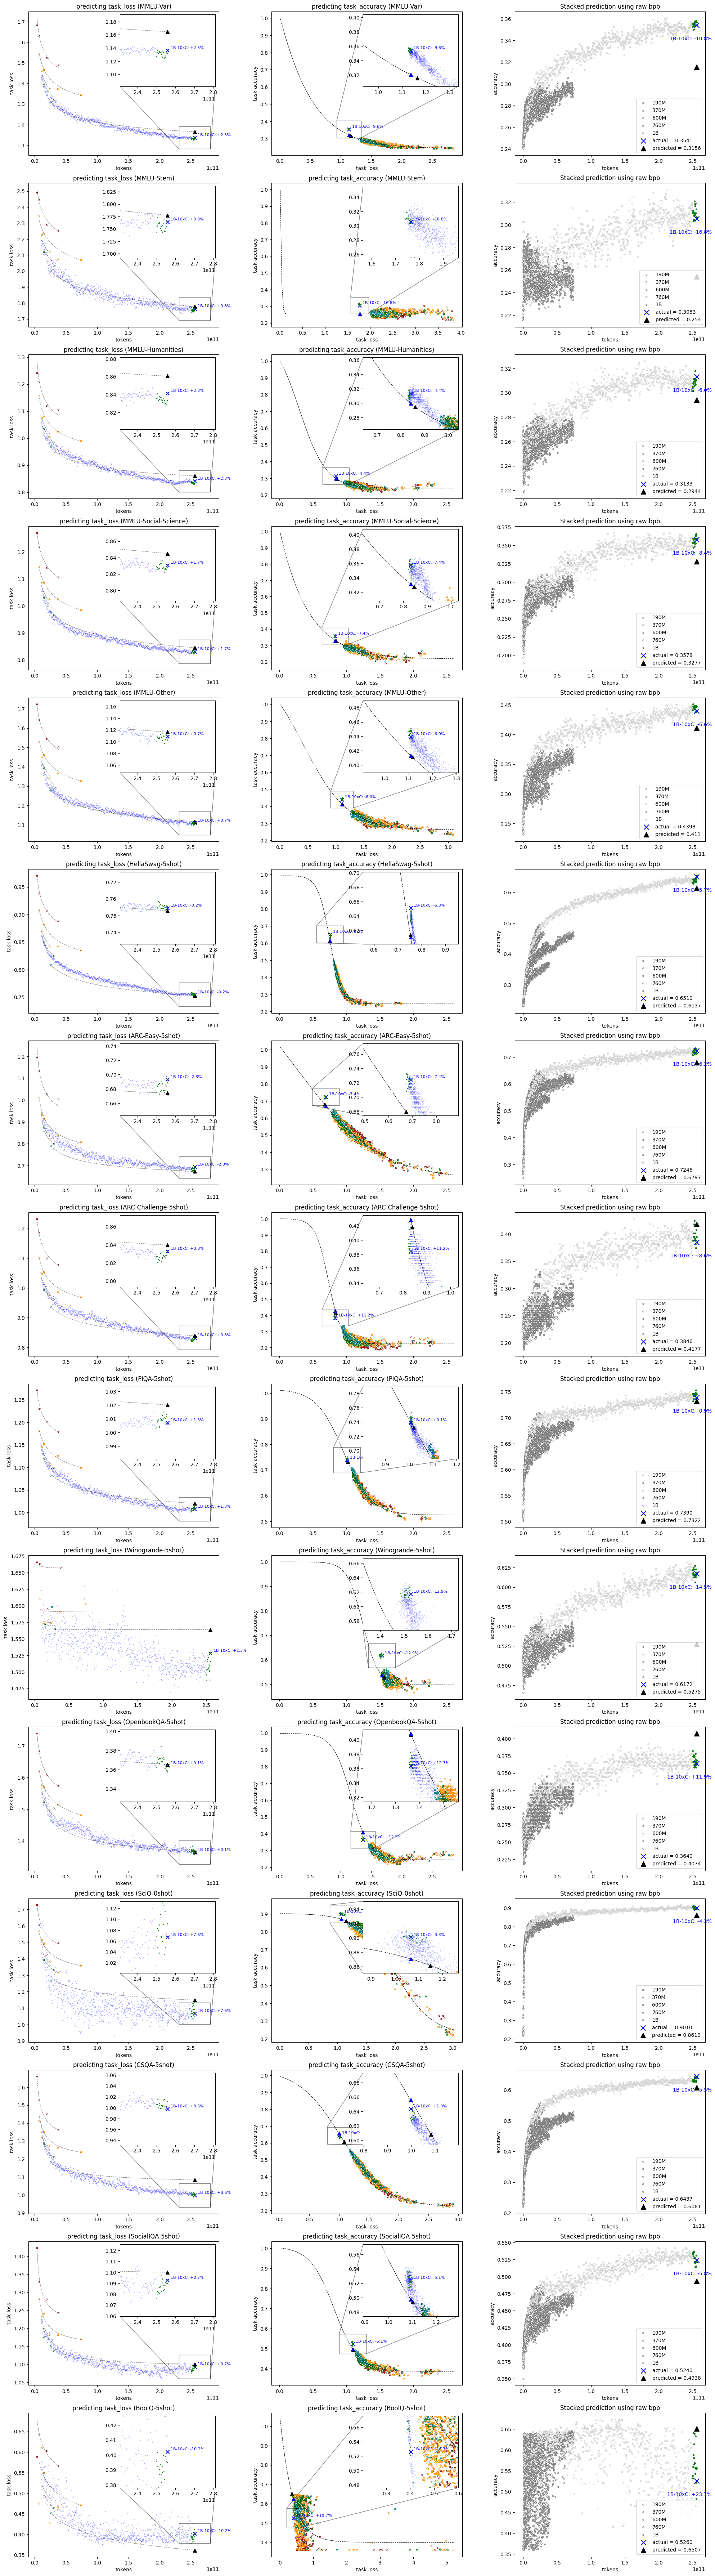

In [5]:
# from a_david_noise_utils import get_all_data_by_name, get_dataframe, plot_step1, plot_step2, fit_step1, fit_step2, get_predicted_error, get_last_n_predicted_error, plot_stacked, run_stacked
# from a_david_noise_utils import BASELINE_BY_TASK_NAME, TASKS
# import matplotlib.pyplot as plt

from a_david_noise_utils import run_stacked

step1_error, step2_error, stacked_error = run_stacked(all_configs)

### New Analysis

In [91]:
from IPython.display import display, Markdown
display(Markdown(r'$$\text{relative error} = \frac{|\text{pred}-\text{actual}|}{\text{actual}}\times100\%$$'))
display(Markdown(r'$$\text{mean error} = \frac{1}{n}\sum_{i=1}^n(\text{pred}-\text{actual}_i)$$'))
display(Markdown(r'$$\text{CV} = \frac{\text{Std. Dev. (last n points)}}{\text{Mean (last n points)}}\times100\%$$'))
display(Markdown(r'$$\text{relative mean error} = \frac{\text{Mean Error}(\text{last n points})}{\text{Mean (last n points)}}\times100\%$$'))
# display(Markdown(r'$$\text{normalized mean error} = \frac{\text{Mean Error}(\text{last n points})}{\text{Std. Dev. (last n points)}}$$'))
display(Markdown(r'$$\text{z-score} = \frac{\text{Mean Error}(\text{last n points})}{\text{Std. Dev. (last n points)}}$$'))

$$\text{relative error} = \frac{|\text{pred}-\text{actual}|}{\text{actual}}\times100\%$$

$$\text{mean error} = \frac{1}{n}\sum_{i=1}^n(\text{pred}-\text{actual}_i)$$

$$\text{CV} = \frac{\text{Std. Dev. (last n points)}}{\text{Mean (last n points)}}\times100\%$$

$$\text{relative mean error} = \frac{\text{Mean Error}(\text{last n points})}{\text{Mean (last n points)}}\times100\%$$

$$\text{z-score} = \frac{\text{Mean Error}(\text{last n points})}{\text{Std. Dev. (last n points)}}$$

In [99]:
import pandas as pd
import numpy as np

def get_results_table(error_results):
    results = pd.DataFrame()
    model_data = error_results['1B-10xC']
    for benchmark_name, data in model_data.items():
        # Compute results
        y_lastn = data['y_lastn']
        y_lastn_mean = data['y_lastn_mean']
        y_lastn_std = data['y_lastn_std']
        y_lastn_coeff_var = data['y_lastn_coeff_var']
        
        row_data = {
            ('Target (1B-10xC)', 'pred'): round(data['y_pred'], 2),
            ('Target (1B-10xC)', 'mean'): round(y_lastn_mean, 2), 
            ('Target (1B-10xC)', 'min'): round(min(y_lastn), 2),
            ('Target (1B-10xC)', 'max'): round(max(y_lastn), 2),
            ('Target (1B-10xC)', 'range'): round(max(y_lastn) - min(y_lastn), 4),
            ('Target (1B-10xC)', 'std'): round(y_lastn_std, 4),
            ('Target (1B-10xC)', '1 CI [upper, lower]'): f'{[round(y_lastn_mean-y_lastn_std, 4), round(y_lastn_mean+y_lastn_std, 4)]}',
            # ('Target (1B-10xC)', '2 CI [upper, lower]'): f'{[round(y_lastn_mean-(2*y_lastn_std), 4), round(y_lastn_mean+(2*y_lastn_std), 4)]}',
            # ('Target (1B-10xC)', 'z-score'): round((data['y_pred'] - y_lastn_mean)/y_lastn_std, 2),
            # ('Target (1B-10xC)', 'CV'): f'{(y_lastn_coeff_var * 100):.2f}%'
            ('Target (1B-10xC)', 'CV'): f'{(y_lastn_coeff_var * 100):.2f}%'
        }
        
        # Compute absolute error
        abs_error = np.array(data['abs_error_lastn'])
        row_data.update({
            (f'Abs error (using last {N_LAST_CKPTS} checkpoints)', 'mean'): round(abs_error.mean(), 3),
            (f'Abs error (using last {N_LAST_CKPTS} checkpoints)', 'min'): round(abs_error.min(), 3),
            (f'Abs error (using last {N_LAST_CKPTS} checkpoints)', 'max'): round(abs_error.max(), 3),
            (f'Abs error (using last {N_LAST_CKPTS} checkpoints)', 'range'): round(abs_error.max() - abs_error.min(), 3),
            (f'Abs error (using last {N_LAST_CKPTS} checkpoints)', 'std'): round(abs_error.std(), 4),
            # (f'Abs error (using last {N_LAST_CKPTS} checkpoints)', 'z-score'): round(abs_error.std(), 2)
        })
        
        # Compute relative error
        rel_error = np.array(data['rel_error_lastn']) * 100
        rel_error_mean = np.array(data['rel_error_lastn_mean']) * 100
        row_data.update({
            (f'Rel error (using last {N_LAST_CKPTS} checkpoints)', 'mean'): f"{rel_error_mean:.2f}%",
            (f'Rel error (using last {N_LAST_CKPTS} checkpoints)', 'min'): f"{rel_error.min():.2f}%",
            (f'Rel error (using last {N_LAST_CKPTS} checkpoints)', 'max'): f"{rel_error.max():.2f}%", 
            (f'Rel error (using last {N_LAST_CKPTS} checkpoints)', 'range'): f"{(rel_error.max() - rel_error.min()):.2f}%",
            (f'Rel error (using last {N_LAST_CKPTS} checkpoints)', 'std'): f"{(rel_error.std()):.2f}%"
        })

        # Compute normalized/relative mean error
        nrmse_lastn_range = data['nrmse_lastn_range']
        nrmse_lastn_mean = data['nrmse_lastn_mean']
        nrmse_lastn_std = data['nrmse_lastn_std']
        rme_lastn = data['rme_lastn']
        nrme_lastn_std = data['nrme_lastn_std']

        row_data.update({
            (f'Normalized Error', 'rme_lastn'): f"{rme_lastn*100:.2f}%",
            (f'Normalized Error', 'nrme_lastn_std'): round(nrme_lastn_std, 2),
        })
        
        # Create DataFrame row with MultiIndex columns
        df_row = pd.DataFrame([row_data], index=[benchmark_name])
        results = pd.concat([results, df_row])

    # Group columns by first level of MultiIndex
    grouped_results = results.copy()
    grouped_results.columns = pd.MultiIndex.from_tuples(grouped_results.columns)

    return grouped_results

In [100]:
print('All statistics for step 1 prediction (ordered by absolute std. dev.):')
grouped_results = get_results_table(step1_error)
grouped_results = grouped_results.sort_values(by=('Target (1B-10xC)', 'std'), ascending=False)
display(grouped_results)

print('All statistics for stacked prediction (ordered by relative std. dev.):')
grouped_results = get_results_table(stacked_error)
grouped_results = grouped_results.sort_values(by=('Target (1B-10xC)', 'CV'), ascending=False)
display(grouped_results)

All statistics for step 1 prediction (ordered by absolute std. dev.):


Target (1B-10xC)                                    \
                                pred  mean   min   max   range     std   
SciQ-0shot                      1.15  1.08  1.03  1.13  0.0980  0.0288   
Winogrande-5shot                1.56  1.51  1.49  1.53  0.0423  0.0117   
BoolQ-5shot                     0.36  0.39  0.38  0.43  0.0479  0.0106   
MMLU-Stem                       1.78  1.76  1.74  1.77  0.0299  0.0086   
ARC-Easy-5shot                  0.67  0.68  0.67  0.70  0.0240  0.0065   
OpenbookQA-5shot                1.37  1.37  1.36  1.38  0.0269  0.0059   
CSQA-5shot                      1.08  1.00  1.00  1.02  0.0196  0.0056   
SocialIQA-5shot                 1.10  1.09  1.08  1.10  0.0212  0.0053   
MMLU-Other                      1.12  1.11  1.10  1.11  0.0181  0.0044   
MMLU-Var                        1.16  1.13  1.12  1.14  0.0116  0.0034   
MMLU-Social-Science             0.85  0.83  0.82  0.84  0.0138  0.0034   
ARC-Challenge-5shot             0.84  0.83  0.82  0.83  0.0125  0.0034   
MMLU-Humanities                 0.86  0.83  0.83  0.84  0.0119  0.0032   
PiQA-5shot                      1.02  1.01  1.00  1.02  0.0119  0.0030   
HellaSwag-5shot                 0.75  0.76  0.75  0.76  0.0050  0.0013   

                                                \
                    1 CI [upper, lower]     CV   
SciQ-0shot             [1.0522, 1.1099]  2.67%   
Winogrande-5shot       [1.4972, 1.5205]  0.77%   
BoolQ-5shot             [0.384, 0.4051]  2.68%   
MMLU-Stem              [1.7482, 1.7654]  0.49%   
ARC-Easy-5shot            [0.677, 0.69]  0.96%   
OpenbookQA-5shot       [1.3619, 1.3738]  0.43%   
CSQA-5shot             [0.9992, 1.0104]  0.55%   
SocialIQA-5shot        [1.0816, 1.0921]  0.49%   
MMLU-Other             [1.1026, 1.1113]  0.39%   
MMLU-Var               [1.1284, 1.1352]  0.30%   
MMLU-Social-Science    [0.8255, 0.8323]  0.42%   
ARC-Challenge-5shot    [0.8237, 0.8305]  0.41%   
MMLU-Humanities        [0.8313, 0.8378]  0.39%   
PiQA-5shot              [1.006, 1.0119]  0.29%   
HellaSwag-5shot         [0.754, 0.7566]  0.17%   

                    Abs error (using last 20 checkpoints)                \
                                                     mean    min    max   
SciQ-0shot                                          0.067  0.015  0.113   
Winogrande-5shot                                    0.055  0.035  0.077   
BoolQ-5shot                                        -0.034 -0.065 -0.017   
MMLU-Stem                                           0.021  0.004  0.034   
ARC-Easy-5shot                                     -0.010 -0.023  0.001   
OpenbookQA-5shot                                   -0.002 -0.019  0.008   
CSQA-5shot                                          0.079  0.068  0.087   
SocialIQA-5shot                                     0.013  0.003  0.024   
MMLU-Other                                          0.009  0.002  0.020   
MMLU-Var                                            0.033  0.028  0.040   
MMLU-Social-Science                                 0.016  0.009  0.023   
ARC-Challenge-5shot                                 0.012  0.007  0.019   
MMLU-Humanities                                     0.026  0.019  0.031   
PiQA-5shot                                          0.011  0.005  0.017   
HellaSwag-5shot                                    -0.002 -0.006 -0.001   

                                   Rel error (using last 20 checkpoints)  \
                     range     std                                  mean   
SciQ-0shot           0.098  0.0288                                 6.23%   
Winogrande-5shot     0.042  0.0117                                 3.64%   
BoolQ-5shot          0.048  0.0106                                -8.52%   
MMLU-Stem            0.030  0.0086                                 1.18%   
ARC-Easy-5shot       0.024  0.0065                                -1.40%   
OpenbookQA-5shot     0.027  0.0059                                -0.17%   
CSQA-5shot           0.020

All statistics for stacked prediction (ordered by relative std. dev.):


Target (1B-10xC)                                    \
                                pred  mean   min   max   range     std   
BoolQ-5shot                     0.65  0.56  0.47  0.64  0.1760  0.0456   
ARC-Challenge-5shot             0.42  0.40  0.37  0.42  0.0502  0.0123   
OpenbookQA-5shot                0.41  0.37  0.36  0.38  0.0240  0.0068   
MMLU-Social-Science             0.33  0.36  0.34  0.37  0.0254  0.0062   
MMLU-Stem                       0.25  0.31  0.30  0.32  0.0174  0.0049   
SocialIQA-5shot                 0.49  0.53  0.51  0.54  0.0230  0.0072   
MMLU-Humanities                 0.29  0.31  0.30  0.32  0.0163  0.0034   
HellaSwag-5shot                 0.61  0.64  0.63  0.65  0.0250  0.0066   
ARC-Easy-5shot                  0.68  0.72  0.71  0.73  0.0246  0.0071   
CSQA-5shot                      0.61  0.63  0.63  0.64  0.0180  0.0057   
MMLU-Other                      0.41  0.45  0.44  0.45  0.0133  0.0036   
Winogrande-5shot                0.53  0.62  0.61  0.63  0.0213  0.0049   
PiQA-5shot                      0.73  0.74  0.73  0.75  0.0210  0.0047   
MMLU-Var                        0.32  0.36  0.35  0.36  0.0081  0.0020   
SciQ-0shot                      0.86  0.90  0.89  0.91  0.0170  0.0042   

                                                \
                    1 CI [upper, lower]     CV   
BoolQ-5shot             [0.516, 0.6073]  8.12%   
ARC-Challenge-5shot    [0.3832, 0.4078]  3.12%   
OpenbookQA-5shot       [0.3615, 0.3751]  1.84%   
MMLU-Social-Science    [0.3497, 0.3621]  1.74%   
MMLU-Stem              [0.3056, 0.3154]  1.57%   
SocialIQA-5shot         [0.519, 0.5334]  1.38%   
MMLU-Humanities         [0.3061, 0.313]  1.11%   
HellaSwag-5shot        [0.6329, 0.6461]  1.03%   
ARC-Easy-5shot         [0.7148, 0.7289]  0.98%   
CSQA-5shot             [0.6274, 0.6387]  0.89%   
MMLU-Other             [0.4417, 0.4488]  0.80%   
Winogrande-5shot       [0.6129, 0.6226]  0.79%   
PiQA-5shot             [0.7384, 0.7478]  0.63%   
MMLU-Var               [0.3533, 0.3573]  0.57%   
SciQ-0shot             [0.8968, 0.9051]  0.46%   

                    Abs error (using last 20 checkpoints)                \
                                                     mean    min    max   
BoolQ-5shot                                         0.089  0.010  0.186   
ARC-Challenge-5shot                                 0.022 -0.007  0.043   
OpenbookQA-5shot                                    0.039  0.025  0.049   
MMLU-Social-Science                                -0.028 -0.038 -0.012   
MMLU-Stem                                          -0.057 -0.067 -0.050   
SocialIQA-5shot                                    -0.032 -0.043 -0.020   
MMLU-Humanities                                    -0.015 -0.024 -0.007   
HellaSwag-5shot                                    -0.026 -0.040 -0.015   
ARC-Easy-5shot                                     -0.042 -0.054 -0.029   
CSQA-5shot                                         -0.025 -0.036 -0.018   
MMLU-Other                                         -0.034 -0.040 -0.027   
Winogrande-5shot                                   -0.090 -0.100 -0.079   
PiQA-5shot                                         -0.011 -0.021  0.000   
MMLU-Var                                           -0.040 -0.042 -0.034   
SciQ-0shot                                         -0.039 -0.048 -0.031   

                                   Rel error (using last 20 checkpoints)  \
                     range     std                                  mean   
BoolQ-5shot          0.176  0.0456                                15.86%   
ARC-Challenge-5shot  0.050  0.0123                                 5.62%   
OpenbookQA-5shot     0.024  0.0068                                10.62%   
MMLU-Social-Science  0.025  0.0062                                -7.94%   
MMLU-Stem            0.017  0.0049                               -18.21%   
SocialIQA-5shot      0.023  0.0072                                -6.17%   
MMLU-Humanities      0.016

In [101]:
def make_fancy(grouped_results):
    columns_to_keep = [
        ('Target (1B-10xC)', 'std'),
        ('Target (1B-10xC)', 'CV'),
        (f'Abs error (using last {N_LAST_CKPTS} checkpoints)', 'min'),
        (f'Abs error (using last {N_LAST_CKPTS} checkpoints)', 'max'),
        (f'Abs error (using last {N_LAST_CKPTS} checkpoints)', 'mean'),
        (f'Abs error (using last {N_LAST_CKPTS} checkpoints)', 'std'),
        (f'Abs error (using last {N_LAST_CKPTS} checkpoints)', 'range'),
        (f'Rel error (using last {N_LAST_CKPTS} checkpoints)', 'min'),
        (f'Rel error (using last {N_LAST_CKPTS} checkpoints)', 'max'),
        (f'Rel error (using last {N_LAST_CKPTS} checkpoints)', 'mean'),
        (f'Rel error (using last {N_LAST_CKPTS} checkpoints)', 'std'),
        (f'Rel error (using last {N_LAST_CKPTS} checkpoints)', 'range'),
    ]

    grouped_results = grouped_results[columns_to_keep]

    new_columns = [
        ('Target (1B-10xC)', 'Absolute Std') if col == ('Target (1B-10xC)', 'std')
        else ('Target (1B-10xC)', 'Relative Std (CV)') if col == ('Target (1B-10xC)', 'CV')
        else col
        for col in grouped_results.columns
    ]

    grouped_results.columns = pd.MultiIndex.from_tuples(new_columns)
    # grouped_results = grouped_results.sort_values(by=('Target (1B-10xC)', 'Relative Std (CV)'), ascending=False)
    grouped_results = grouped_results.sort_values(by=('Target (1B-10xC)', 'Absolute Std'), ascending=False)

    return grouped_results

print(f'Statistics for step 1 prediction using last {N_LAST_CKPTS} checkpoints:')
grouped_results = get_results_table(step1_error)
grouped_results = make_fancy(grouped_results)
grouped_results = grouped_results.sort_values(by=('Target (1B-10xC)', 'Absolute Std'), ascending=False)
display(grouped_results)

print(f'Statistics for stacked prediction using last {N_LAST_CKPTS} checkpoints:')
grouped_results = get_results_table(stacked_error)
grouped_results = make_fancy(grouped_results)
grouped_results = grouped_results.sort_values(by=('Target (1B-10xC)', 'Relative Std (CV)'), ascending=False)
display(grouped_results)

# merge into one table
print(f'Simplified results')
grouped_results_1 = make_fancy(get_results_table(step1_error))
grouped_results_2 = make_fancy(get_results_table(stacked_error))
# Map task names and filter merged results
task_mapping = {
    'MMLU-Var': 'mmlu avg var',
    'HellaSwag-5shot': 'hellaswag 5-shot', 
    'ARC-Easy-5shot': 'arc easy 5-shot',
    'ARC-Challenge-5shot': 'arc challenge 5-shot',
    'BoolQ-5shot': 'boolq 5-shot',
    'CSQA-5shot': 'csqa 5-shot',
    'OpenbookQA-5shot': 'openbookqa 5-shot',
    'PiQA-5shot': 'piqa 5-shot',
    'SocialIQA-5shot': 'socialiqa 5-shot',
    'Winogrande-5shot': 'winogrande 5-shot'
}

# Filter rows based on task mapping keys

target_cols = [col for col in grouped_results_1.columns if col[0] == 'Target (1B-10xC)']
step1_results = grouped_results_1[target_cols].rename(columns={'Target (1B-10xC)': 'Step 1'})
stacked_results = grouped_results_2[target_cols].rename(columns={'Target (1B-10xC)': 'Stacked'})
step1_results = step1_results.loc[task_mapping.keys()]
step1_results.index = step1_results.index.map(lambda x: task_mapping[x])
stacked_results = stacked_results.loc[task_mapping.keys()]
stacked_results.index = stacked_results.index.map(lambda x: task_mapping[x])

# merged_results = pd.concat([step1_results, stacked_results], axis=1)
# merged_results = merged_results.sort_values(by=('Step 1', 'Absolute Std'), ascending=False)
# display(merged_results)


step1_results = step1_results.sort_values(by=('Step 1', 'Absolute Std'), ascending=False)
display(step1_results)

stacked_results = stacked_results.sort_values(by=('Stacked', 'Relative Std (CV)'), ascending=False)
display(stacked_results)

Statistics for step 1 prediction using last 20 checkpoints:


Target (1B-10xC)                    \
                        Absolute Std Relative Std (CV)   
SciQ-0shot                    0.0288             2.67%   
Winogrande-5shot              0.0117             0.77%   
BoolQ-5shot                   0.0106             2.68%   
MMLU-Stem                     0.0086             0.49%   
ARC-Easy-5shot                0.0065             0.96%   
OpenbookQA-5shot              0.0059             0.43%   
CSQA-5shot                    0.0056             0.55%   
SocialIQA-5shot               0.0053             0.49%   
MMLU-Other                    0.0044             0.39%   
MMLU-Var                      0.0034             0.30%   
MMLU-Social-Science           0.0034             0.42%   
ARC-Challenge-5shot           0.0034             0.41%   
MMLU-Humanities               0.0032             0.39%   
PiQA-5shot                    0.0030             0.29%   
HellaSwag-5shot               0.0013             0.17%   

                    Abs error (using last 20 checkpoints)                \
                                                      min    max   mean   
SciQ-0shot                                          0.015  0.113  0.067   
Winogrande-5shot                                    0.035  0.077  0.055   
BoolQ-5shot                                        -0.065 -0.017 -0.034   
MMLU-Stem                                           0.004  0.034  0.021   
ARC-Easy-5shot                                     -0.023  0.001 -0.010   
OpenbookQA-5shot                                   -0.019  0.008 -0.002   
CSQA-5shot                                          0.068  0.087  0.079   
SocialIQA-5shot                                     0.003  0.024  0.013   
MMLU-Other                                          0.002  0.020  0.009   
MMLU-Var                                            0.028  0.040  0.033   
MMLU-Social-Science                                 0.009  0.023  0.016   
ARC-Challenge-5shot                                 0.007  0.019  0.012   
MMLU-Humanities                                     0.019  0.031  0.026   
PiQA-5shot                                          0.005  0.017  0.011   
HellaSwag-5shot                                    -0.006 -0.001 -0.002   

                                   Rel error (using last 20 checkpoints)  \
                        std  range                                   min   
SciQ-0shot           0.0288  0.098                                 1.36%   
Winogrande-5shot     0.0117  0.042                                 2.28%   
BoolQ-5shot          0.0106  0.048                               -15.28%   
MMLU-Stem            0.0086  0.030                                 0.24%   
ARC-Easy-5shot       0.0065  0.024                                -3.33%   
OpenbookQA-5shot     0.0059  0.027                                -1.38%   
CSQA-5shot           0.0056  0.020                                 6.65%   
SocialIQA-5shot      0.0053  0.021                                 0.28%   
MMLU-Other           0.0044  0.018                                 0.14%   
MMLU-Var             0.0034  0.012                                 2.48%   
MMLU-Social-Science  0.0034  0.014                                 1.06%   
ARC-Challenge-5shot  0.0034  0.012                                 0.80%   
MMLU-Humanities      0.0032  0.012                                 2.28%   
PiQA-5shot           0.0030  0.012                                 0.49%   
HellaSwag-5shot      0.0013  0.005                                -0.74%   

                                                    
                        max    mean    std   range  
SciQ-0shot           10.96%   6.23%  2.81%   9.60%  
Winogrande-5shot      5.19%   3.64%  0.80%   2.91%  
BoolQ-5shot          -4.54%  -8.52%  2.38%  10.74%  
MMLU-Stem             1.95%   1.18%  0.49%   1.72%  
ARC-Easy-5shot        0.11%  -1.40%  0.94%   3.45%  
OpenbookQA-5shot      0.58%  -0.17%  0.43%   1.95%  
CSQA-5shot            8.75%   7.84%  0.5

Statistics for stacked prediction using last 20 checkpoints:


Target (1B-10xC)                    \
                        Absolute Std Relative Std (CV)   
BoolQ-5shot                   0.0456             8.12%   
ARC-Challenge-5shot           0.0123             3.12%   
OpenbookQA-5shot              0.0068             1.84%   
MMLU-Social-Science           0.0062             1.74%   
MMLU-Stem                     0.0049             1.57%   
SocialIQA-5shot               0.0072             1.38%   
MMLU-Humanities               0.0034             1.11%   
HellaSwag-5shot               0.0066             1.03%   
ARC-Easy-5shot                0.0071             0.98%   
CSQA-5shot                    0.0057             0.89%   
MMLU-Other                    0.0036             0.80%   
Winogrande-5shot              0.0049             0.79%   
PiQA-5shot                    0.0047             0.63%   
MMLU-Var                      0.0020             0.57%   
SciQ-0shot                    0.0042             0.46%   

                    Abs error (using last 20 checkpoints)                \
                                                      min    max   mean   
BoolQ-5shot                                         0.010  0.186  0.089   
ARC-Challenge-5shot                                -0.007  0.043  0.022   
OpenbookQA-5shot                                    0.025  0.049  0.039   
MMLU-Social-Science                                -0.038 -0.012 -0.028   
MMLU-Stem                                          -0.067 -0.050 -0.057   
SocialIQA-5shot                                    -0.043 -0.020 -0.032   
MMLU-Humanities                                    -0.024 -0.007 -0.015   
HellaSwag-5shot                                    -0.040 -0.015 -0.026   
ARC-Easy-5shot                                     -0.054 -0.029 -0.042   
CSQA-5shot                                         -0.036 -0.018 -0.025   
MMLU-Other                                         -0.040 -0.027 -0.034   
Winogrande-5shot                                   -0.100 -0.079 -0.090   
PiQA-5shot                                         -0.021  0.000 -0.011   
MMLU-Var                                           -0.042 -0.034 -0.040   
SciQ-0shot                                         -0.048 -0.031 -0.039   

                                   Rel error (using last 20 checkpoints)  \
                        std  range                                   min   
BoolQ-5shot          0.0456  0.176                                 1.52%   
ARC-Challenge-5shot  0.0123  0.050                                -1.65%   
OpenbookQA-5shot     0.0068  0.024                                 6.65%   
MMLU-Social-Science  0.0062  0.025                               -10.33%   
MMLU-Stem            0.0049  0.017                               -20.86%   
SocialIQA-5shot      0.0072  0.023                                -8.05%   
MMLU-Humanities      0.0034  0.016                                -7.42%   
HellaSwag-5shot      0.0066  0.025                                -6.17%   
ARC-Easy-5shot       0.0071  0.025                                -7.31%   
CSQA-5shot           0.0057  0.018                                -5.54%   
MMLU-Other           0.0036  0.013                                -8.90%   
Winogrande-5shot     0.0049  0.021                               -15.93%   
PiQA-5shot           0.0047  0.021                                -2.76%   
MMLU-Var             0.0020  0.008                               -11.86%   
SciQ-0shot           0.0042  0.017                                -5.29%   

                                                      
                         max     mean    std   range  
BoolQ-5shot           39.94%   15.86%  9.67%  38.42%  
ARC-Challenge-5shot   11.52%    5.62%  3.22%  13.17%  
OpenbookQA-5shot      13.80%   10.62%  2.02%   7.15%  
MMLU-Social-Science   -3.62%   -7.94%  1.62%   6.71%  
MMLU-Stem            -16.33%  -18.21%  1.28%   4.53%  
SocialIQA-5shot       -3.94%   -6.17%  1.29%   4.11%  
MMLU-Humanities       -2

Simplified results


Step 1                  
                     Absolute Std Relative Std (CV)
winogrande 5-shot          0.0117             0.77%
boolq 5-shot               0.0106             2.68%
arc easy 5-shot            0.0065             0.96%
openbookqa 5-shot          0.0059             0.43%
csqa 5-shot                0.0056             0.55%
socialiqa 5-shot           0.0053             0.49%
mmlu avg var               0.0034             0.30%
arc challenge 5-shot       0.0034             0.41%
piqa 5-shot                0.0030             0.29%
hellaswag 5-shot           0.0013             0.17%

Stacked                  
                     Absolute Std Relative Std (CV)
boolq 5-shot               0.0456             8.12%
arc challenge 5-shot       0.0123             3.12%
openbookqa 5-shot          0.0068             1.84%
socialiqa 5-shot           0.0072             1.38%
hellaswag 5-shot           0.0066             1.03%
arc easy 5-shot            0.0071             0.98%
csqa 5-shot                0.0057             0.89%
winogrande 5-shot          0.0049             0.79%
piqa 5-shot                0.0047             0.63%
mmlu avg var               0.0020             0.57%

In [105]:
def make_fancy(grouped_results):
    columns_to_keep = [
        (f'Abs error (using last {N_LAST_CKPTS} checkpoints)', 'mean'),
        # (f'Rel error (using last {N_LAST_CKPTS} checkpoints)', 'mean'),
        (f'Normalized Error', 'rme_lastn'),
        ('Target (1B-10xC)', 'std'),
        ('Target (1B-10xC)', 'CV'),
        (f'Normalized Error', 'nrme_lastn_std'),
    ]

    grouped_results = grouped_results[columns_to_keep]

    new_columns = [
             ('Target (1B-10xC)', 'Absolute Std') if col == ('Target (1B-10xC)', 'std')
        else ('Target (1B-10xC)', 'Relative Std (CV)') if col == ('Target (1B-10xC)', 'CV')
        else (f'Abs error (using last {N_LAST_CKPTS} checkpoints)', 'Mean Absolute Error') if col == (f'Abs error (using last {N_LAST_CKPTS} checkpoints)', 'mean')
        else (f'Normalized Error', 'Mean Relative Error') if col == (f'Normalized Error', 'rme_lastn')
        else (f'Normalized Error', 'Z-score') if col == (f'Normalized Error', 'nrme_lastn_std')
        else col
        for col in grouped_results.columns
    ]

    grouped_results.columns = pd.MultiIndex.from_tuples(new_columns)
    # grouped_results = grouped_results.sort_values(by=('Target (1B-10xC)', 'Relative Std (CV)'), ascending=False)
    grouped_results = grouped_results.sort_values(by=('Target (1B-10xC)', 'Absolute Std'), ascending=False)

    return grouped_results

# print(f'Statistics for step 1 prediction using last {N_LAST_CKPTS} checkpoints:')
# grouped_results = get_results_table(step1_error)
# grouped_results = make_fancy(grouped_results)
# grouped_results = grouped_results.sort_values(by=('Target (1B-10xC)', 'Absolute Std'), ascending=False)
# display(grouped_results)

# print(f'Statistics for stacked prediction using last {N_LAST_CKPTS} checkpoints:')
# grouped_results = get_results_table(stacked_error)
# grouped_results = make_fancy(grouped_results)
# grouped_results = grouped_results.sort_values(by=('Target (1B-10xC)', 'Relative Std (CV)'), ascending=False)
# display(grouped_results)

# merge into one table
print(f'Simplified results')
grouped_results_1 = make_fancy(get_results_table(step1_error))
grouped_results_2 = make_fancy(get_results_table(stacked_error))
task_mapping = {
    'MMLU-Var': 'mmlu avg var',
    'HellaSwag-5shot': 'hellaswag 5-shot', 
    'ARC-Easy-5shot': 'arc easy 5-shot',
    'ARC-Challenge-5shot': 'arc challenge 5-shot',
    'BoolQ-5shot': 'boolq 5-shot',
    'CSQA-5shot': 'csqa 5-shot',
    'OpenbookQA-5shot': 'openbookqa 5-shot',
    'PiQA-5shot': 'piqa 5-shot',
    'SocialIQA-5shot': 'socialiqa 5-shot',
    'Winogrande-5shot': 'winogrande 5-shot'
}

target_cols = grouped_results_1.columns
step1_results   = grouped_results_1[target_cols].rename(columns={k[0]: 'Step 1' for k in grouped_results_1.columns.values})
stacked_results = grouped_results_2[target_cols].rename(columns={k[0]: 'Stacked' for k in grouped_results_2.columns.values})
step1_results         = step1_results.loc[task_mapping.keys()]
stacked_results       = stacked_results.loc[task_mapping.keys()]
step1_results.index   = step1_results.index.map(lambda x: task_mapping[x])
stacked_results.index = stacked_results.index.map(lambda x: task_mapping[x])

merged_results = pd.concat([step1_results, stacked_results], axis=1)
# merged_results = merged_results.sort_values(by=('Step 1', 'Z-score'), ascending=False)
merged_results = merged_results.sort_values(by=('Stacked', 'Z-score'), ascending=False)
# merged_results = merged_results.sort_values(by=('Stacked', 'Relative Std (CV)'), ascending=False)
display(merged_results)

# step1_results = step1_results.sort_values(by=('Step 1', 'Absolute Std'), ascending=False)
# display(step1_results)

# merged_results = merged_results.sort_values(by=('Stacked', 'Relative Std (CV)'), ascending=False)
# display(merged_results)

Simplified results


Step 1                                   \
                     Mean Absolute Error Mean Relative Error Absolute Std   
openbookqa 5-shot                 -0.002              -0.17%       0.0059   
boolq 5-shot                      -0.034              -8.52%       0.0106   
arc challenge 5-shot               0.012               1.51%       0.0034   
piqa 5-shot                        0.011               1.11%       0.0030   
hellaswag 5-shot                  -0.002              -0.32%       0.0013   
csqa 5-shot                        0.079               7.84%       0.0056   
socialiqa 5-shot                   0.013               1.20%       0.0053   
arc easy 5-shot                   -0.010              -1.40%       0.0065   
winogrande 5-shot                  0.055               3.64%       0.0117   
mmlu avg var                       0.033               2.89%       0.0034   

                                                           Stacked  \
                     Relative Std (CV) Z-score Mean Absolute Error   
openbookqa 5-shot                0.43%   -0.40               0.039   
boolq 5-shot                     2.68%   -3.18               0.089   
arc challenge 5-shot             0.41%    3.70               0.022   
piqa 5-shot                      0.29%    3.79              -0.011   
hellaswag 5-shot                 0.17%   -1.92              -0.026   
csqa 5-shot                      0.55%   14.16              -0.025   
socialiqa 5-shot                 0.49%    2.47              -0.032   
arc easy 5-shot                  0.96%   -1.47              -0.042   
winogrande 5-shot                0.77%    4.69              -0.090   
mmlu avg var                     0.30%    9.61              -0.040   

                                                                         \
                     Mean Relative Error Absolute Std Relative Std (CV)   
openbookqa 5-shot                 10.62%       0.0068             1.84%   
boolq 5-shot                      15.86%       0.0456             8.12%   
arc challenge 5-shot               5.62%       0.0123             3.12%   
piqa 5-shot                       -1.46%       0.0047             0.63%   
hellaswag 5-shot                  -4.04%       0.0066             1.03%   
csqa 5-shot                       -3.95%       0.0057             0.89%   
socialiqa 5-shot                  -6.17%       0.0072             1.38%   
arc easy 5-shot                   -5.84%       0.0071             0.98%   
winogrande 5-shot                -14.61%       0.0049             0.79%   
mmlu avg var                     -11.16%       0.0020             0.57%   

                              
                     Z-score  
openbookqa 5-shot       5.78  
boolq 5-shot            1.95  
arc challenge 5-shot    1.80  
piqa 5-shot            -2.32  
hellaswag 5-shot       -3.93  
csqa 5-shot            -4.42  
socialiqa 5-shot       -4.48  
arc easy 5-shot        -5.96  
winogrande 5-shot     -18.55  
mmlu avg var          -19.49

#### Takeaways
- The coefficient of variation (CV) is also known as the relative standard deviation.
- **Absolute vs. Relative Std**: Absolute and relative standard deviation give the same ordering of benchmarks for stacked error, but not step 1 error. This is because the **the target loss is higher for some metrics, underestimating the relative std. and relative error for some benchmarks.**
    - Thus, we look at absolute std. for step 1, and relative std. for stacked error, and this ordering of difficulty is consistent with the noise we observe in the above plot.
- **Excluding benchmarks**: For step 1, WinoGrande and BoolQ have an outlier absolute standard deviation.
- **Interpreting relative error across final checkpoints**: The "max/min/range" column under "Rel error" illustrates the spread of possible relative errors. 
- **Z-score**: The z-score provides a measure of error which accounts for the noise of the prediction target. This can be interpreted as the number of standard deviations away from the mean our predicted value lies.     
    - This tells us that our MMLU predictions for step 1 are particularly bad even though the relative error is low, since the standard deviation of the prediction target is also very low.
    - This also tells us that our ARC-Challenge prediction for step 2 is quite good (z-score=1.8) despite having a high relative error (mean relative error=15.86%), because the noise of the prediction target is particularly high.

For Jesse:
- I calculated the std. dev. of the prediction errors. Would it be worth reporting the mean +- 1 std. dev. of the relative error? 
    - In the table, we would interpret the real step 1 ARC-E error as having a 68% chance of occuring within -1.40% +- 0.94% (obviously assuming the relative error is normally distributed among step-to-step noise)
    - Additionally, the empirical std of the relative errors is about the same as relative std of the prediction targets. Is this worth highlighting? This could mean that the relative std has the interpretation of closely estimating the observed noise around the target.
